In [2]:
import os
import warnings
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
from google.cloud import bigquery
warnings.filterwarnings('ignore')

load_dotenv(dotenv_path="/Users/akosua/Desktop/PeriPrice/.env")
PROJECT_ID = os.getenv("PROJECT_ID")
DATASET = os.getenv("CURATED_DATASET")

client = bigquery.Client(project=PROJECT_ID)
ARTIFACT_DIR = "../artifacts/eda"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

In [3]:
# BigQuery client (relies on ADC or service account JSON env var)
client = bigquery.Client(project=PROJECT_ID)

def q(sql: str) -> pd.DataFrame:
    """Run a SQL query and return a pandas DataFrame."""
    return client.query(sql).to_dataframe()

def save_df(df: pd.DataFrame, name: str):
    """Save a DataFrame to CSV under artifacts."""
    path = os.path.join(ARTIFACT_DIR, f"{name}.csv")
    df.to_csv(path, index=False)
    print(f"Saved: {path}")

def save_fig(name: str):
    """Save the current matplotlib figure to PNG under artifacts."""
    path = os.path.join(ARTIFACT_DIR, f"{name}.png")
    plt.savefig(path, bbox_inches="tight", dpi=150)
    print(f"Saved: {path}")

In [5]:
sql = f"""
SELECT
  COUNT(*) AS nrows,
  MIN(date) AS min_date,
  MAX(date) AS max_date
FROM `{PROJECT_ID}.{DATASET}.fct_sales_features`;
"""

df_shape = q(sql)
display(df_shape)
save_df(df_shape, "01_shape_date_range")


,nrows,min_date,max_date
0,31702536,2013-01-01,2017-08-15


Saved: ../artifacts/eda/01_shape_date_range.csv


In [6]:
sql = f"""
SELECT
  SUM(CASE WHEN onpromotion IS NULL THEN 1 ELSE 0 END) AS null_onpromotion,
  SUM(CASE WHEN family IS NULL THEN 1 ELSE 0 END) AS null_family,
  SUM(CASE WHEN class IS NULL THEN 1 ELSE 0 END) AS null_class,
  SUM(CASE WHEN city IS NULL THEN 1 ELSE 0 END) AS null_city,
  SUM(CASE WHEN state IS NULL THEN 1 ELSE 0 END) AS null_state,
  SUM(CASE WHEN type IS NULL THEN 1 ELSE 0 END) AS null_type,
  SUM(CASE WHEN cluster IS NULL THEN 1 ELSE 0 END) AS null_cluster,
  SUM(CASE WHEN oil_price IS NULL THEN 1 ELSE 0 END) AS null_oil_price,
  SUM(CASE WHEN oil_price_ma7 IS NULL THEN 1 ELSE 0 END) AS null_oil_ma7,
  SUM(CASE WHEN oil_price_ma30 IS NULL THEN 1 ELSE 0 END) AS null_oil_ma30
FROM `{PROJECT_ID}.{DATASET}.fct_sales_features`;
"""
df_nulls = q(sql)
display(df_nulls)
save_df(df_nulls, "02_missingness")


,null_onpromotion,null_family,null_class,null_city,null_state,null_type,null_cluster,null_oil_price,null_oil_ma7,null_oil_ma30
0,0,0,0,0,0,0,0,146,146,146


Saved: ../artifacts/eda/02_missingness.csv


In [7]:
sql = f"""
SELECT
  APPROX_QUANTILES(unit_sales, 100)[OFFSET(1)]  AS p01_sales,
  APPROX_QUANTILES(unit_sales, 100)[OFFSET(50)] AS p50_sales,
  APPROX_QUANTILES(unit_sales, 100)[OFFSET(95)] AS p95_sales,
  AVG(unit_sales) AS mean_sales,
  AVG(log_sales)  AS mean_log_sales
FROM `{PROJECT_ID}.{DATASET}.fct_sales_features`;
"""
df_dist = q(sql)
display(df_dist)
save_df(df_dist, "03_target_distribution")

,p01_sales,p50_sales,p95_sales,mean_sales,mean_log_sales
0,0.736,5.0,36.888,10.585408,1.936789


Saved: ../artifacts/eda/03_target_distribution.csv


,dow,avg_log_sales
0,1,2.095714
1,2,1.911102
2,3,1.887356
3,4,1.924234
4,5,1.798567
5,6,1.894922
6,7,2.031580


Saved: ../artifacts/eda/04_seasonality_by_dow.csv
Saved: ../artifacts/eda/04_seasonality_by_dow.png


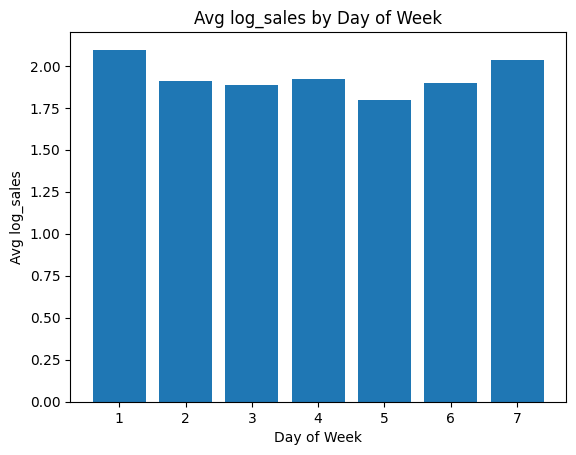

In [8]:
# Seasonality by day of week
sql = f"""
SELECT dow, AVG(log_sales) AS avg_log_sales
FROM `{PROJECT_ID}.{DATASET}.fct_sales_features`
GROUP BY dow
ORDER BY dow;
"""
df_dow = q(sql)
display(df_dow)
save_df(df_dow, "04_seasonality_by_dow")

# Plot
plt.figure()
plt.bar(df_dow["dow"], df_dow["avg_log_sales"])
plt.xlabel("Day of Week")
plt.ylabel("Avg log_sales")
plt.title("Avg log_sales by Day of Week")
save_fig("04_seasonality_by_dow")
plt.show()


,month,avg_log_sales
0,1,1.961707
1,2,1.906648
2,3,1.944007
3,4,1.906545
4,5,1.922539
5,6,1.930430
6,7,1.940920
7,8,1.906092
8,9,1.963098
9,10,1.942496


Saved: ../artifacts/eda/05_seasonality_by_month.csv
Saved: ../artifacts/eda/05_seasonality_by_month.png


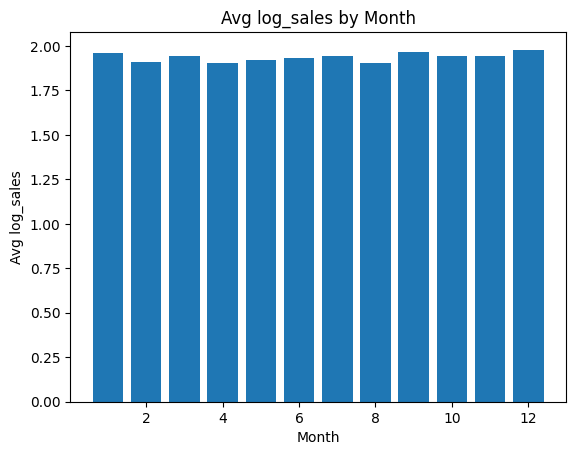

In [9]:
# Seasonality by month
sql = f"""
SELECT month, AVG(log_sales) AS avg_log_sales
FROM `{PROJECT_ID}.{DATASET}.fct_sales_features`
GROUP BY month
ORDER BY month;
"""
df_month = q(sql)
display(df_month)
save_df(df_month, "05_seasonality_by_month")

plt.figure()
plt.bar(df_month["month"], df_month["avg_log_sales"])
plt.xlabel("Month")
plt.ylabel("Avg log_sales")
plt.title("Avg log_sales by Month")
save_fig("05_seasonality_by_month")
plt.show()


In [10]:
sql = f"""
SELECT
  AVG(CASE WHEN onpromotion THEN log_sales END) - 
  AVG(CASE WHEN NOT onpromotion THEN log_sales END) AS avg_lift_log
FROM `{PROJECT_ID}.{DATASET}.fct_sales_features`;
"""
df_lift_overall = q(sql)
display(df_lift_overall)
save_df(df_lift_overall, "07_promo_lift_overall")


,avg_lift_log
0,0.156879


Saved: ../artifacts/eda/07_promo_lift_overall.csv


In [12]:
sql = f"""
SELECT family,
  AVG(CASE WHEN onpromotion THEN log_sales END) -
  AVG(CASE WHEN NOT onpromotion THEN log_sales END) AS lift_log
FROM `{PROJECT_ID}.{DATASET}.fct_sales_features`
GROUP BY family
ORDER BY lift_log DESC
LIMIT 50;
"""
df_lift_family = q(sql)
display(df_lift_family.head(20))
save_df(df_lift_family, "08_promo_lift_by_family_top50")


,family,lift_log
0,PRODUCE,0.263145
1,MEATS,0.195014
2,BREAD/BAKERY,0.111675
3,POULTRY,0.077760
4,EGGS,0.045853
5,SEAFOOD,0.040427
6,DELI,0.030556
7,DAIRY,-0.010106
8,PREPARED FOODS,-0.126415


Saved: ../artifacts/eda/08_promo_lift_by_family_top50.csv


In [13]:
sql = f"""
SELECT type, cluster,
       AVG(log_sales) AS avg_log_sales,
       AVG(CASE WHEN onpromotion THEN 1 ELSE 0 END) AS promo_rate,
       COUNT(*) AS n
FROM `{PROJECT_ID}.{DATASET}.fct_sales_features`
GROUP BY type, cluster
ORDER BY avg_log_sales DESC
LIMIT 50;
"""
df_store_het = q(sql)
display(df_store_het.head(20))
save_df(df_store_het, "09_store_heterogeneity_top50")


,type,cluster,avg_log_sales,promo_rate,n
0,A,5,2.723773,0.092653,944865
1,A,11,2.483511,0.095673,1939307
2,D,8,2.300787,0.092031,2682644
3,A,17,2.263678,0.090180,837185
4,A,14,2.166050,0.095880,3518387
5,C,12,1.963703,0.135370,470251
6,D,1,1.878120,0.095480,2189280
7,D,2,1.853866,0.106179,1187668
8,D,13,1.836019,0.104509,2999288
9,B,6,1.834375,0.144427,3060021


Saved: ../artifacts/eda/09_store_heterogeneity_top50.csv


In [14]:
sql = f"""
SELECT
  CORR(log_sales, oil_price)       AS r_oil,
  CORR(log_sales, oil_price_ma7)   AS r_oil_ma7,
  CORR(log_sales, oil_price_ma30)  AS r_oil_ma30,
  CORR(log_sales, pct_change_1d)   AS r_oil_d1,
  CORR(log_sales, pct_change_7d)   AS r_oil_d7
FROM `{PROJECT_ID}.{DATASET}.fct_sales_features`;
"""
df_oil_corr = q(sql)
display(df_oil_corr)
save_df(df_oil_corr, "10_oil_correlations")

,r_oil,r_oil_ma7,r_oil_ma30,r_oil_d1,r_oil_d7
0,0.010017,0.010641,0.012657,-0.005801,-0.008083


Saved: ../artifacts/eda/10_oil_correlations.csv


In [15]:
sql = f"""
SELECT
  COUNT(DISTINCT store_nbr) AS stores,
  COUNT(DISTINCT item_nbr)  AS items,
  COUNT(DISTINCT family)    AS families,
  COUNT(DISTINCT class)     AS classes,
  COUNT(DISTINCT city)      AS cities,
  COUNT(DISTINCT state)     AS states,
  COUNT(DISTINCT type)      AS types,
  COUNT(DISTINCT cluster)   AS clusters
FROM `{PROJECT_ID}.{DATASET}.fct_sales_features`;
"""
df_card = q(sql)
display(df_card)
save_df(df_card, "11_cardinalities")

,stores,items,families,classes,cities,states,types,clusters
0,54,986,9,95,22,16,5,17


Saved: ../artifacts/eda/11_cardinalities.csv


In [16]:
sql = f"""
WITH agg AS (
  SELECT store_nbr, item_nbr, COUNTIF(unit_sales > 0) AS days_sold
  FROM `{PROJECT_ID}.{DATASET}.fct_sales_features`
  GROUP BY store_nbr, item_nbr
)
SELECT * FROM agg ORDER BY days_sold ASC LIMIT 100;
"""
df_cold = q(sql)
display(df_cold.head(20))
save_df(df_cold, "12_cold_spots_top100")


,store_nbr,item_nbr,days_sold
0,34,582864,1
1,24,1239853,1
2,17,1503891,1
3,47,1696029,1
4,25,584032,1
5,4,623317,1
6,37,789907,1
7,4,1489869,1
8,14,1489873,1
9,7,584101,1


Saved: ../artifacts/eda/12_cold_spots_top100.csv
